# 14.2 Fine-tuning
- transfer learning: using a pre-trained model and fine-tuning it for a new task
- 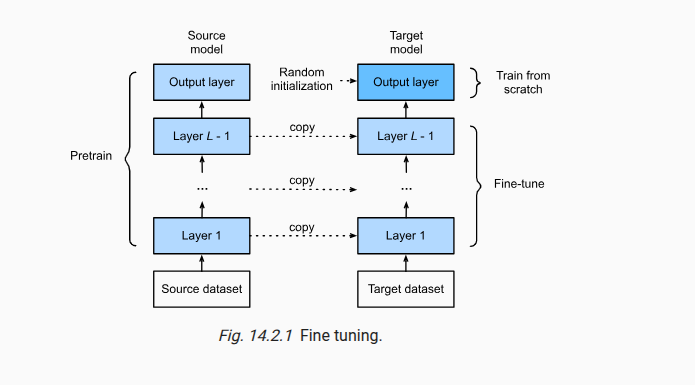
- 

In [ ]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [3]:
#@save
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

In [4]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, "train"))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, "test"))

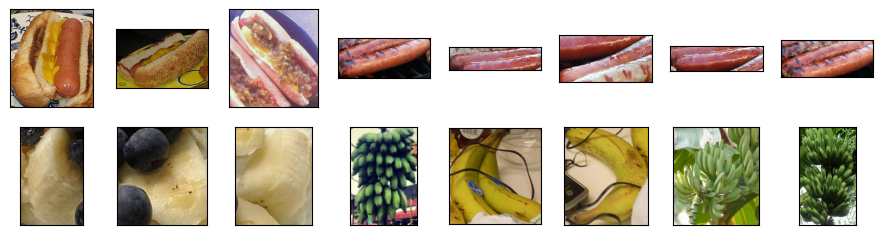

In [5]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4)
d2l.plt.show()  

In [ ]:
# Specify the means and standard deviations of the three RGB channels to
# standardize each channel
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_imgs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize
])
test_imgs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize
])

In [9]:
pretrained_net = torchvision.models.resnet18(weights="DEFAULT")
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
finetuned_net = torchvision.models.resnet18(weights="DEFAULT")
finetuned_net.fc = nn.Linear(finetuned_net.fc.in_features, 2) # change output to 2 classes
nn.init.xavier_uniform_(finetuned_net.fc.weight)

Parameter containing:
tensor([[-0.1037,  0.0920,  0.0168,  ...,  0.0526, -0.0866,  0.0221],
        [-0.0738, -0.0562, -0.0164,  ..., -0.0360, -0.0162,  0.0733]],
       requires_grad=True)

In [12]:
# If `param_group=True`, the model parameters in the output layer will be
# updated using a learning rate ten times greater

def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train'), transform=train_augs),
    batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters() if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{"params": params_1x}, {"params": net.fc.parameters(), "lr": learning_rate * 10}], lr=learning_rate, weight_decay=.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=.001)
    
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)


In [ ]:
train_fine_tuning(finetuned_net, 5e-5)


In [ ]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2) # change output to 2 classes
train_fine_tuning(scratch_net, 5e-3, param_group=False)